# Implementing a Quantum Teleportation protocol

In [10]:
# Required imports

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from numpy import pi, random

Consider two observers, Alice (A) and Bob (B) which share a given quantum entangled state. It is said that A and B share a unit of entanglement, encoded in an e-bit. We shall take this e-bit to be the Bell state $\ket{\phi^+}$.

Alice wants to communicate a third qubit (Q) to Bob via a perfect quantum communication channel. This might be an arbitrary, unknown qubit which might be in any correlated state with a third system. 

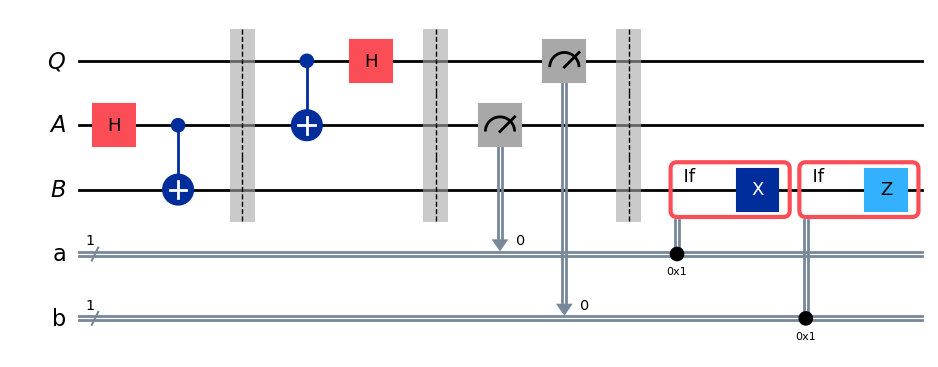

In [11]:
# Build the quantum circuit

q = QuantumRegister(1, 'Q') # Control qubit
alice = QuantumRegister(1, 'A') # Alice target qubit
bob = QuantumRegister(1, 'B') # Bob target qubit

# Classical registers for the measurements
areg = ClassicalRegister(1, 'a')
breg = ClassicalRegister(1, 'b')

protocol = QuantumCircuit(q, alice, bob, areg, breg)

# Prepare the Alice and Bob entangled state
protocol.h(alice)
protocol.cx(alice,bob)
protocol.barrier() # Creates a visual separation in the diagram

# Alice's operations on her qubit and Q
protocol.cx(q, alice)
protocol.h(q)
protocol.barrier()

# Alice measures her state and the third qubit and sends classical bits to Bob
protocol.measure(alice, areg)
protocol.measure(q, breg)
protocol.barrier()

# Bob uses the classical bits to perform operations conditioned to the Alice's measurements
with protocol.if_test((areg,1)):
    # Performs a X gate if bit a = 1
    protocol.x(bob) 

with protocol.if_test((breg,1)):
    # Performs a Z gate if bit b = 1
    protocol.z(bob)
    
# Display de protocol

display(protocol.draw('mpl'))




Since Q might be in any arbitrary state, we wish to test the protocol with a randomly generated single-qubit state. We initialize Q in the quantum state 0 and apply the corresponding random gate.

Hence, the testing circuit will apply the random gate to Q initially, then run the teleportation circuit, then applies the inverse random gate to B and measures. The outcome should be 0 with certainty. 

In [12]:
# We intialize Q in the state 0 and then apply a random quantum gate on it

r_gate = UGate(
    theta = random.random() * 2 * pi,
    phi = random.random() * 2 * pi,
    lam = random.random() * 2 * pi
)

display(r_gate.to_matrix())

array([[-0.98542545+0.j        ,  0.13633009+0.10173887j],
       [ 0.1310338 +0.10847503j,  0.23251493+0.95760123j]])

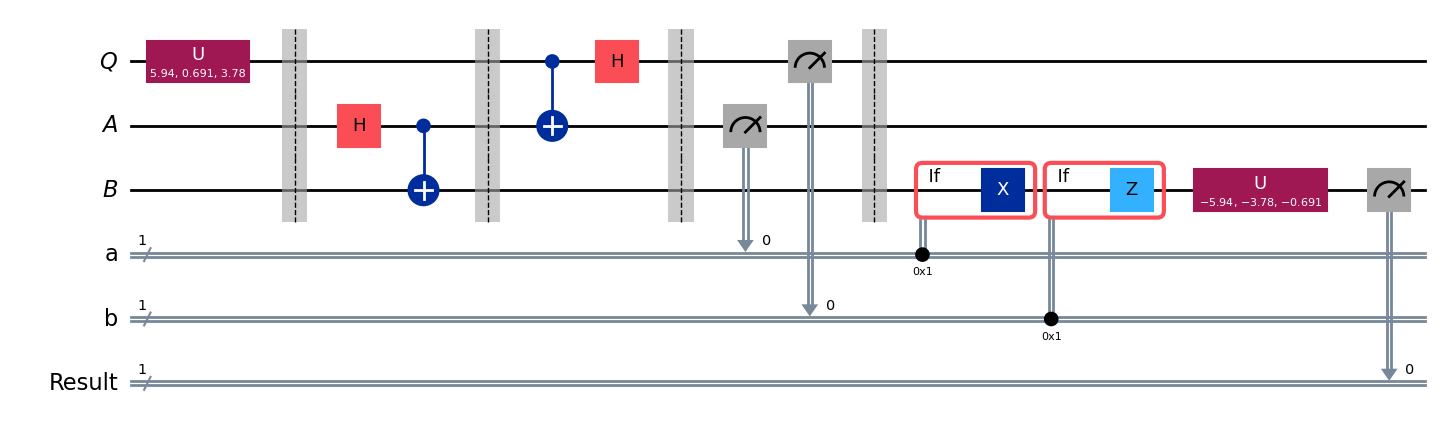

In [13]:
# Let's recreate the previous quantum circuit but including the random gate acting on Q

test_protocol = QuantumCircuit(q, alice, bob, areg, breg)

test_protocol.append(r_gate, q)
test_protocol.barrier()

# We can append the rest of the previous protocol circuit to the new one
test_protocol = test_protocol.compose(protocol)

# Finally, apply the inverse of the random unitary to B and measure.
test_protocol.append(r_gate.inverse(), bob)

result = ClassicalRegister(1, 'Result')
test_protocol.add_register(result)

test_protocol.measure(bob, result)

display(test_protocol.draw('mpl'))

We now run the Aer Simulator on the circuit for testing. Having initialized Q in the state 0, this should be always the bottom or leftmost bit. This indicates that Q was succesfully teleported into B

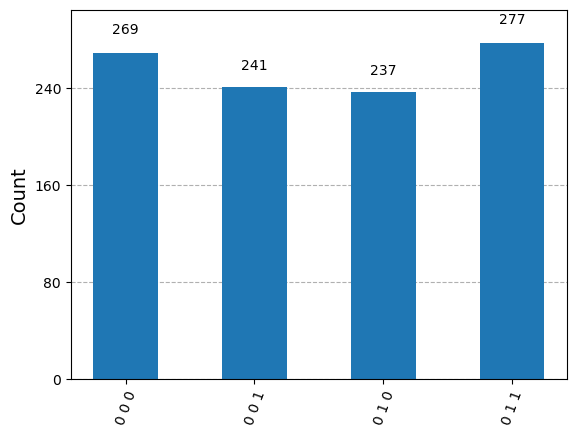

In [15]:
result = AerSimulator().run(test_protocol).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

We can filter the statistics to look just on the teleported qubit, i.e. the final B state

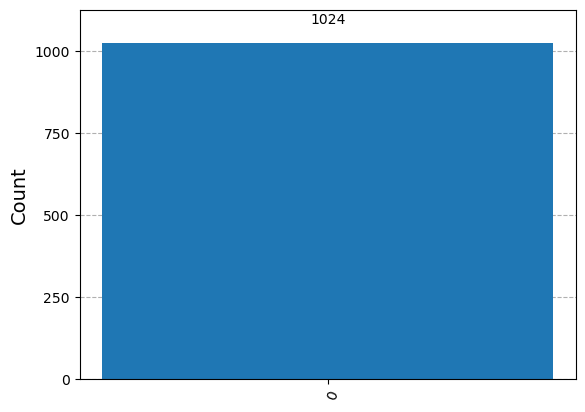

In [16]:
filtered_statistics = marginal_distribution(statistics, [2])
display(plot_histogram(filtered_statistics))

In summary, quantum teleportation is a protocol that allows for the transmission of one qubit using two classical bits of communication, at the cost of one e-bit of entanglement. Notice that the entangled state is destroyed in the process, meaning the final states of A and B will not be entangled anymore. 